# Issues with Image Translation

In [39]:
# Imports
import numpy as np

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch import optim
from torch.optim import SGD, Adam

import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt 
%matplotlib inline



# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load data
data_directory = 'D:/book-implementations/packt-modern-computer-vision-with-pytorch/03-building-deep-nn-with-pytorch/images/FMNIST'

fmnist = datasets.FashionMNIST(
    data_directory,
    download=False,
    train=True
    )

tr_images = fmnist.data
tr_targets = fmnist.targets 

val_fmnist = datasets.FashionMNIST(
    data_directory,
    download=False,
    train=False
    )

val_images = val_fmnist.data 
val_targets = val_fmnist.targets 

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)

    def __len__(self): 
        return len(self.x)

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


32768it [00:12, 2567.23it/s]                            
4423680it [00:11, 370040.82it/s]                              
8192it [00:01, 4503.05it/s]             
26427392it [00:30, 6737987.58it/s]                              

In [5]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [6]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [7]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(epoch)

    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0


26427392it [01:01, 428878.56it/s] 


1
2
3
4


Text(0.5, 1.0, 'Trouser')

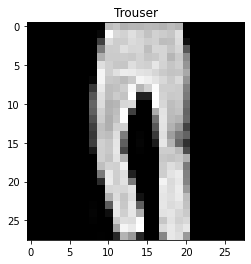

In [10]:
# Load a random image

# ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [12]:
# Preprocess for model

img = tr_images[ix]/255
img = img.view(28*28)
img = img.to(device)

# Obtain Prediction
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([4.9248274e-04, 9.9947667e-01, 1.4717492e-07, 1.6903476e-05,
       2.4458805e-07, 1.8027817e-12, 1.3554227e-05, 8.0111238e-17,
       5.1050280e-09, 1.0501828e-11], dtype=float32)

1st Index, 'Trouser' has highest probability

Text(0.5, 1.0, 'Trouser')

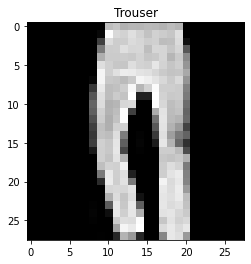

In [ ]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [29]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

In [30]:
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([4.9248274e-04, 9.9947667e-01, 1.4717492e-07, 1.6903476e-05,
       2.4458805e-07, 1.8027817e-12, 1.3554227e-05, 8.0111238e-17,
       5.1050280e-09, 1.0501828e-11], dtype=float32)

## Translation

Translate image -5 pixel from left and +5 pixel to the right

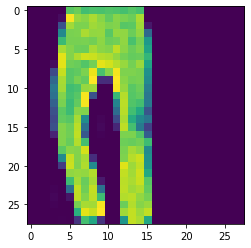

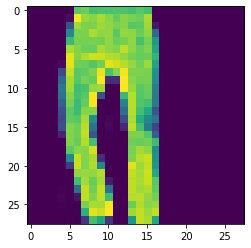

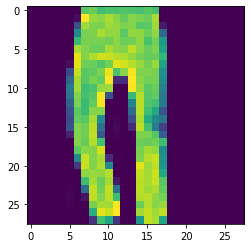

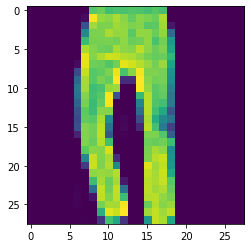

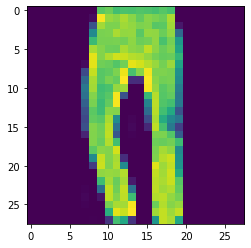

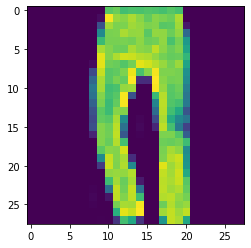

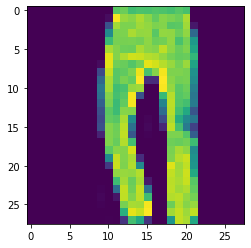

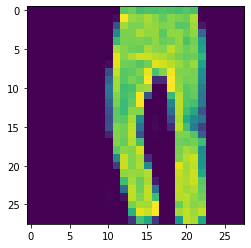

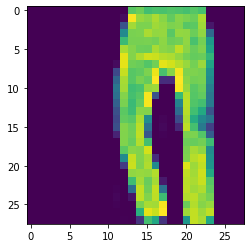

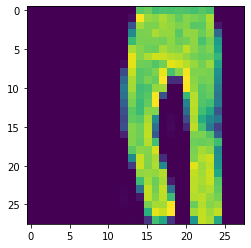

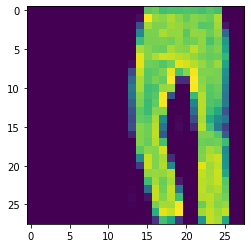

In [46]:
preds = []

for px in range(-5, 6):

    # Preprocess Image
    img = tr_images[ix]/255
    img = img.view(28,28)

    # Roll
    img2 = np.roll(
        a=img,
        shift=px,
        axis=1
    )

    # Plot Image
    plt.imshow(img2)
    plt.show()

    # Convert to tensor
    img3 = torch.tensor(img2).view(28*28).to(device)

    # Obtain prediction
    np_output = model(img3).cpu().detach().numpy()

    # Obtain probability
    preds.append(
        np.exp(np_output) / np.sum(np.exp(np_output))
    )


<AxesSubplot:title={'center':'Prediction of each class for various translations'}>

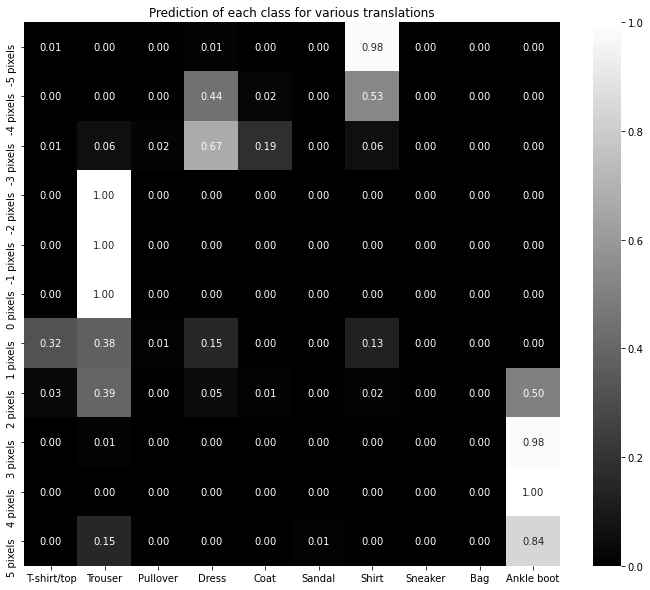

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plt.title('Prediction of each class for various translations')

sns.heatmap(
    data=np.array(preds),
    annot=True,
    ax=ax,
    fmt='.2f',
    xticklabels=fmnist.classes,
    yticklabels=[
        str(i) + ' pixels' for i in range(-5,6)
        ],
        cmap='gray'
)

Changing position of image caused model to output incorrect predictions. This is because all training images were at the centre. Thus, CNNs help overcome this problem.